<a href="https://colab.research.google.com/github/pvt-16/Projects/blob/DataScienceMasters/scc_461_py_Decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Basics

In [47]:
import sklearn as skl
from sklearn import datasets
import pandas as pd
import warnings
#from sklearn.tree import DecisionTreeClassifier
import time 
import matplotlib.pyplot as plt
import graphviz

warnings.filterwarnings('ignore')

In [28]:
wineDataset = datasets.load_wine()

In [ ]:
wineDataset

In [29]:
featureSet, targetSet = wineDataset.data, wineDataset.target

In [30]:
dfFeatures = pd.DataFrame(featureSet, columns = wineDataset.feature_names)
dfTarget = pd.DataFrame(targetSet, columns = ["Class"])

## EDA

In [31]:
dfFeatures.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [32]:
dfFeatures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

In [33]:
dfTarget['Class'].value_counts()

1    71
0    59
2    48
Name: Class, dtype: int64

## Feature Engineering

### Handle Categorical variables

encoding

Ref: https://www.kaggle.com/prashant111/decision-tree-classifier-tutorial#12.-Feature-Engineering-


In [34]:
#import category_encoders as ce

## Train and Test datasets

In [35]:
trainFeatureSet, testFeatureSet, trainTargetSet, testTargetSet = skl.model_selection.train_test_split(featureSet, targetSet,
                                                                                                      train_size = 0.7, test_size = 0.3,
                                                                                                      shuffle = True)

## Helper methods

In [36]:
def getEvaluationMetrics(predictedTargetSet): 
  accuracy = skl.metrics.accuracy_score(testTargetSet, predictedTargetSet)
  precision = skl.metrics.precision_score(testTargetSet, predictedTargetSet, average='micro')
  recall = skl.metrics.recall_score(testTargetSet, predictedTargetSet, average='micro')
  f1score = skl.metrics.f1_score(testTargetSet, predictedTargetSet, average='micro')
  classificationReport = skl.metrics.classification_report(testTargetSet, predictedTargetSet)
  return {
      accuracy: accuracy,
      precision: precision,
      recall: recall,
      f1score: f1score,
      classificationReport: classificationReport
  }

In [37]:
def printEvaluationMetrics(predictedTargetSet):
  evalMetrics = getEvaluationMetrics(predictedTargetSet)
  print (evalMetrics)
  print(f"Accuracy score of model: {evalMetrics.accuracy}")
  print(f"Precision score of model: {evalMetrics.precision}")
  print(f"Recall score of model: {evalMetrics.recall}")
  print(f"F1 of model: {evalMetrics.f1score}")
  print(f"Classification report of model: {evalMetrics.classificationReport}")

In [38]:
def getTimeTaken(startTime, endTime):
  return round((endTime - startTime) * 100, 5)

In [39]:
def getTrainingPerformanceMetrics():
  return {
      timeTaken: timeTaken
  }

## Decision Tree

In [40]:
#@title 

class DecisionTree:     #Declaring DecisionTree
    #Constructor
    def __init__(self , data: list = None) -> None:
        self.dataset = data
        self.featureSet = data.loc[:,data.iloc(-1)] or 0
        self.targetSet = data.loc[:,data.iloc(-1)] or 0
        
    def _prechecksOnDataSet(self):
        dataSetClass0Elements =  list(filter(lambda item : targetSet == 0, self.dataset))
        dataSetClass1Elements =  list(filter(lambda item : targetSet == 1, self.dataset))
        #If all elements of the dataset belong to the same class, we can't split the tree.
        if (len(dataSetClass0Elements)== 0 or len(dataSetClass1Elements) == 0):
            return False
        return ""

    def _modelFit(self, featureSet, targetSet):
        self.featureSet = featureSet
        self.targetSet = targetSet
    
    def _findBestSplit(self) -> tuple():
        gini= split = 0
        leftTree = rightTree = []
        
        #Since the dataset has only continuous integer features, we first sort it in ascending order to calculate the mid points
        sortedData = sorted(self.dataset.copy(),  key = lambda x: x[0])
        midpoints = list(map(lambda x, y: (x[0]+y[0])/2, sortedData[:-1], sortedData[1:]))
        #Get all the midpoints
        midpoints = list(map(lambda x, y: (x[0]+y[0])/2, sortedData[:-1], sortedData[1:]))
        midpoints = list(filter( lambda m: m not in list(map(lambda y: y[0], sortedData)), midpoints))
        if len(midpoints) == 0:
            return False
        #Get Gini Index value and the split point value
        giniIndexVal= self._getGiniIndexValue(midpoints, sortedData)
        if giniIndexVal == False:
            return False
        gini, split = giniIndexVal
        gini = round(gini, 5)
        #We use the mid point value calculated to get the left and right branches of the decision tree
        leftTree = list(filter( lambda x:  x[0] <= split, sortedData))
        rightTree = list(filter( lambda x:  x[0] > split, sortedData))
        return (gini, split, leftTree, rightTree)
    
    #This returns a tuple that has the Gini index value and the midpoint value
    def _getGiniIndexValue(self, midPoints: list, dataset: list) -> tuple():
        localLeftTree = localRightTree = [] = giniValues = []
        #return False
        for midVal in midPoints:
            localLeftTree = list(filter(lambda x: x[0] <= midVal, dataset))
            localRightTree = list(filter(lambda x: x[0] > midVal, dataset))
            D1 = len(localLeftTree); D2 = len(localRightTree); D = len(dataset)

            if D >0:        
                localGiniValue = ( (D1/ D) * (self._giniValue(localLeftTree)) + (D2/ D) * (self._giniValue(localRightTree)))
                giniValues.append((localGiniValue, midVal))

        if len(giniValues) > 0 :
            # returns the tuple with the smallest gini index value
            return sorted(giniValues)[0]
        #Split could not be determined
        return False
    
    def _giniValue(self, tree: list) -> float:
        giniValue =  sumOfProbabilities = 0 
        #Since there are only 2 classes, we are filtering directly by class values 0,1
        #Filter features that belong to Class 0 
        localTreeClass0 = list(filter(lambda item : item[1] == 0, tree))
        #Filter features that belong to Class 1
        localTreeClass1 = list(filter(lambda item : item[1] == 1, tree))
        if len(tree)>0:
            #Gini value is calculated as -> 1 - 'sum of probabilities squared of a feature belonging to a class'
            sumOfProbabilities =  (len(localTreeClass0) / len(tree)) ** 2 + (len(localTreeClass1) / len(tree) ) ** 2 
            giniValue = 1 - sumOfProbabilities
            #return the Gini Index value for this split
            return giniValue
        return False


## sklearn Decision tree


In [41]:
dTreeSkl = skl.tree.DecisionTreeClassifier(criterion='gini', random_state=0) #max_depth=3,

### Train model

In [42]:
dTreeSklStartTime = time.time()
dTreeSkl.fit(trainFeatureSet, trainTargetSet)
dTreeSklEndTime = time.time()
dTreeSklTimeTaken = getTimeTaken(dTreeSklStartTime, dTreeSklEndTime) 

print(f"Time taken to train Decision Tree:", dTreeSklTimeTaken)

Time taken to train Decision Tree: 0.39451


### Test model

In [43]:
predictedValues = dTreeSkl.predict(testFeatureSet)
print(f"Evaluation Metrics:", getEvaluationMetrics(predictedTargetSet = predictedValues))

Evaluation Metrics: {0.9444444444444444: 0.9444444444444444, '              precision    recall  f1-score   support\n\n           0       0.91      1.00      0.95        20\n           1       1.00      0.90      0.95        21\n           2       0.92      0.92      0.92        13\n\n    accuracy                           0.94        54\n   macro avg       0.94      0.94      0.94        54\nweighted avg       0.95      0.94      0.94        54\n': '              precision    recall  f1-score   support\n\n           0       0.91      1.00      0.95        20\n           1       1.00      0.90      0.95        21\n           2       0.92      0.92      0.92        13\n\n    accuracy                           0.94        54\n   macro avg       0.94      0.94      0.94        54\nweighted avg       0.95      0.94      0.94        54\n'}


In [44]:
#trainTargetSet
skl.metrics.accuracy_score(dTreeSkl.predict(trainFeatureSet), trainTargetSet)

1.0

### Visualizing

[Text(125.55000000000001, 195.696, 'color_intensity <= 3.46\ngini = 0.659\nsamples = 124\nvalue = [39, 50, 35]\nclass = class_1'), Text(83.7, 152.208, 'gini = 0.0\nsamples = 40\nvalue = [0, 40, 0]\nclass = class_1'), Text(167.4, 152.208, 'flavanoids <= 1.49\ngini = 0.597\nsamples = 84\nvalue = [39, 10, 35]\nclass = class_0'), Text(83.7, 108.72, 'od280/od315_of_diluted_wines <= 2.56\ngini = 0.054\nsamples = 36\nvalue = [0, 1, 35]\nclass = class_2'), Text(41.85, 65.232, 'gini = 0.0\nsamples = 35\nvalue = [0, 0, 35]\nclass = class_2'), Text(125.55000000000001, 65.232, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]\nclass = class_1'), Text(251.10000000000002, 108.72, 'proline <= 724.5\ngini = 0.305\nsamples = 48\nvalue = [39, 9, 0]\nclass = class_0'), Text(209.25, 65.232, 'hue <= 0.83\ngini = 0.18\nsamples = 10\nvalue = [1, 9, 0]\nclass = class_1'), Text(167.4, 21.744, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0]\nclass = class_0'), Text(251.10000000000002, 21.744, 'gini = 0.0\nsamples = 9\nva

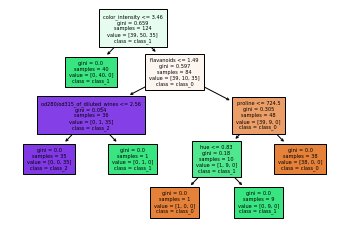

In [79]:
#@title
#print(skl.tree.plot_tree(dTreeSkl, feature_names= wineDataset.feature_names, class_names= wineDataset.target_names, filled=True, fontsize=5))

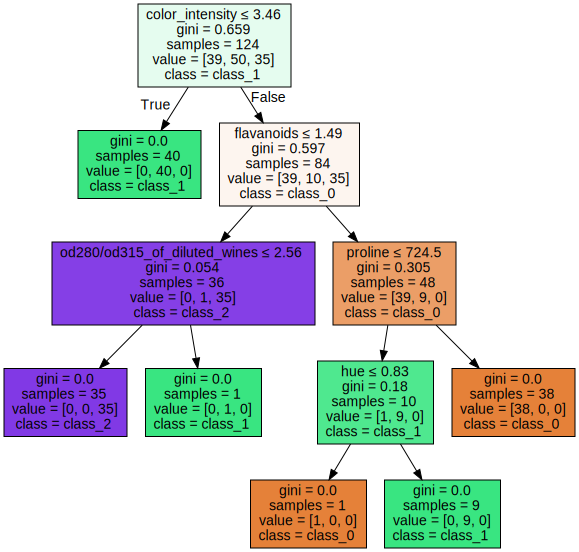

In [67]:
dot_data = skl.tree.export_graphviz(dTreeSkl, out_file=None,  
                filled=True, rounded=False,
                special_characters=True,
                feature_names = wineDataset.feature_names,
                class_names = wineDataset.target_names)
graph = graphviz.Source(dot_data)  
graph